# Data Description:

You are provided with a training set and a test set of images of plant seedlings at various stages of grown. Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the competition is to create a classifier capable of determining a plant's species from a photo.

# 1. Load Libraries and data
The project is from a dataset from Kaggle.
Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data
Note: For project purposes, download only train images folder from Kaggle. (See note at the end of problem statement.)
The dataset has to be downloaded from the above Kaggle website.

Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks)

## 1.1 Import libraries

In [1]:
import os
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
c:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 1.2 Load data

In [2]:
category_names = [] # Build a feature list by searching for folder names
for folder in os.listdir(os.path.join('train', "")):
    category_names.append(folder)
category_names # There are 12 features

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [3]:
# Create a list of file names that contain the seedling images to be analyzed
fie_names_of_seedling = []
for folder_name in category_names:
    # List down a list of file names in a folder that contain seedling pictures
    for file_name in os.listdir(os.path.join('train', folder_name)):
        fie_names_of_seedling.append([folder_name, file_name])

# View the data frame with file names        
train_seedling_df = pd.DataFrame(fie_names_of_seedling, columns=['seedling_category', 'file_name'])
train_seedling_df.sample(6)

,seedling_category,file_name
2928,Maize,1d21b25f9.png
954,Common Chickweed,04526c399.png
4365,Sugar beet,0026b7a30.png
62,Black-grass,3f268bcf8.png
519,Charlock,ae66022e7.png
2503,Loose Silky-bent,6347090c6.png


In [4]:
train_seedling_df.shape # Check the number of images

(4750, 2)

# 1.3 Read and show certain images

In [5]:
# Check for unique number of categories
num_categories = train_seedling_df['seedling_category'].nunique() 

In [6]:
def convert_img_to_np_data(filepath, filename):
    # Load a image file
    image = cv2.imread(os.path.join('train', filepath, filename))
    return image

In [7]:
fig = plt.figure(1, figsize=(5, num_categories))
image_data = []
image_data_category = []
image_data_df = pd.DataFrame()

# Use the information about file locations to load image data into pandas data frame
for index, data in enumerate(train_seedling_df.iterrows()):
    category_name = train_seedling_df.loc[index, 'seedling_category']
    
    # Pass a file name to load for image data
    temp_img_data = convert_img_to_np_data(category_name, train_seedling_df.loc[index, 'file_name'])
    
    # Store the image data into an array                                      
    image_data.append([category_name, temp_img_data])
    image_data_category.append([category_name])
            
# Create a data frame that contains seedling category names and image data
image_data_df = pd.DataFrame(image_data, columns=['category_name', 'img_data'])

#image_data_df['resize_img_data'] = image_data_df['img_data'].map(lambda image : cv2.resize(image, (200, 200))) 
image_data_df.head(5)        

,category_name,img_data
0,Black-grass,"[[[27, 50, 80], [18, 42, 71], [36, 57, 83], [4..."
1,Black-grass,"[[[37, 43, 55], [37, 43, 54], [40, 46, 57], [4..."
2,Black-grass,"[[[24, 32, 45], [21, 30, 44], [22, 30, 45], [2..."
3,Black-grass,"[[[51, 84, 108], [56, 89, 112], [54, 88, 110],..."
4,Black-grass,"[[[165, 162, 162], [165, 161, 163], [160, 157,..."


<Figure size 360x864 with 0 Axes>

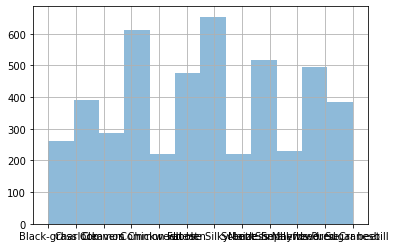

In [8]:
image_data_df['category_name'].hist(bins=12, alpha=0.5)

Data size of various image classes are fairly distributed

In [9]:
image_data_df['img_data'][0:8].map(lambda x:x.shape) # Check for the image sizes

0      (196, 196, 3)
1      (388, 388, 3)
2      (886, 886, 3)
3      (117, 117, 3)
4      (471, 471, 3)
5    (1074, 1074, 3)
6      (251, 251, 3)
7    (1899, 1900, 3)
Name: img_data, dtype: object

The images have different sizes so we have to resize them to fit them to a standard CNN 

In [10]:
image_data_df_backup = image_data_df.copy(deep=True) # Save a backup image

In [11]:
# Resize all images to 100,100
image_data_df['img_data'] = image_data_df_backup['img_data'].map(lambda image : cv2.resize(image, (150, 150))) 

In [12]:
image_data_df['img_data'][0:8].map(lambda x:x.shape)

0    (150, 150, 3)
1    (150, 150, 3)
2    (150, 150, 3)
3    (150, 150, 3)
4    (150, 150, 3)
5    (150, 150, 3)
6    (150, 150, 3)
7    (150, 150, 3)
Name: img_data, dtype: object

A number of sample pictures show that they have different pixels so we resize them to 150, 150.

## 1.4 Visualization a few images

Label is Black-grass


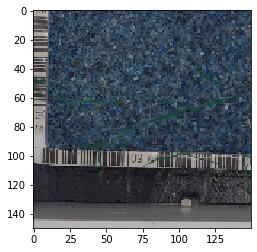

Label is Charlock


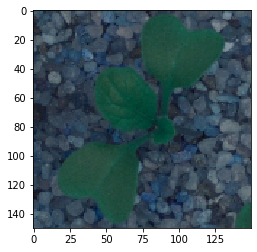

Label is Common Chickweed


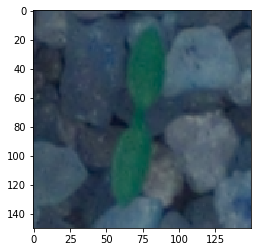

In [13]:
for index in [10,500, 1000]:
    print(f"Label is {image_data_df.loc[index, 'category_name']}")
    plt.imshow(image_data_df.loc[index, 'img_data'])
    plt.show()

# 2.0 Data Pre-processing: (15 Marks)

## 2.1 Normalization

In [14]:
# Normalize the feature values of image data 
X = image_data_df['img_data']/255
X.head(3)

0    [[[0.09803921568627451, 0.18823529411764706, 0...
1    [[[0.1607843137254902, 0.1843137254901961, 0.2...
2    [[[0.08235294117647059, 0.11372549019607843, 0...
Name: img_data, dtype: object

## 2.2 Gaussian Blurring

### 2.2.1 Gaussian Blurring for an image

Original Image:



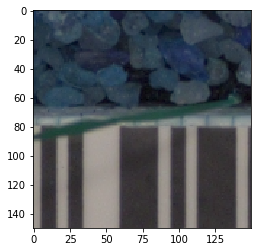


 Output after first gaussian blurring: 



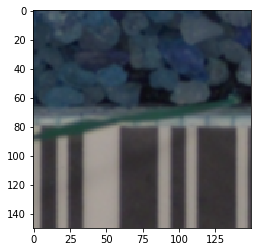


 Output after second gaussian blurring: 



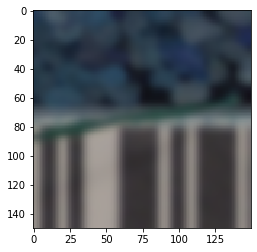

In [15]:
Gaussian1 = cv2.GaussianBlur(image_data_df['img_data'][0], (3, 3), 0)
Gaussian2 = cv2.GaussianBlur(image_data_df['img_data'][0], (15, 15), 0)

print('Original Image:\n')
plt.imshow(image_data_df['img_data'][0])
plt.show()

print('\n Output after first gaussian blurring: \n')
plt.imshow(Gaussian1)
plt.show()

print('\n Output after second gaussian blurring: \n')
plt.imshow(Gaussian2)
plt.show()


## 2.3 Visualize data after pre-processing.

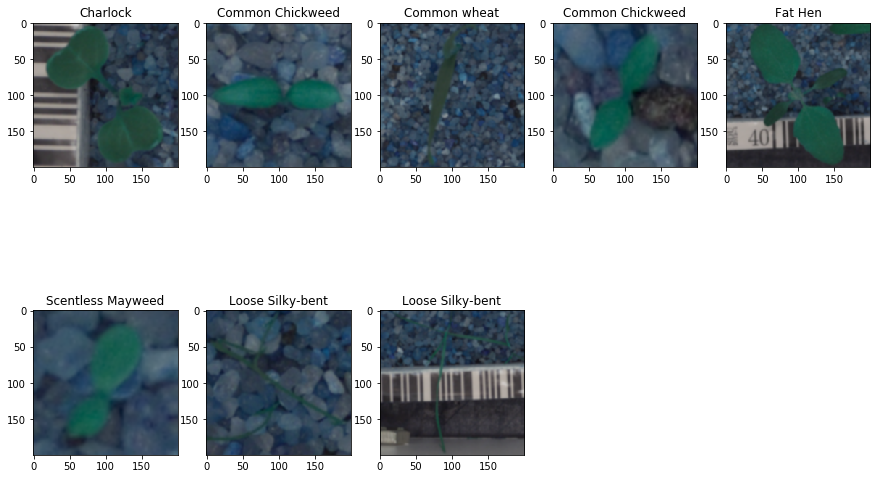

In [15]:
from sklearn.utils import shuffle

# Randomize the sequence of image data
randomized_image_data_df = shuffle(image_data_df.copy(deep=True))
randomized_image_data_df = randomized_image_data_df.iloc[:40, :]

# Apply Gaussian Blurring to the image data
randomized_image_data_df['img_data'] = randomized_image_data_df['img_data'].map(lambda x : cv2.GaussianBlur(x, (5, 5), 0))

# Set the picture size
fig = plt.figure(1, figsize=(15, 15))
randomized_image_data_df.reset_index(drop=True, inplace=True)


for index, df in enumerate(range(8)):
    current_category = str(randomized_image_data_df.loc[index, 'category_name'])

    ax = plt.subplot(3, 5, index+1)
    plt.imshow(randomized_image_data_df.loc[index, 'img_data'])
    plt.title(current_category)
    
plt.show()

In [18]:
randomized_image_data_df.head(5)

,category_name,img_data
0,Fat Hen,"[[[147, 148, 151], [147, 147, 151], [146, 147,..."
1,Loose Silky-bent,"[[[54, 81, 103], [54, 81, 103], [55, 82, 103],..."
2,Shepherds Purse,"[[[50, 62, 79], [49, 62, 79], [49, 62, 78], [4..."
3,Loose Silky-bent,"[[[38, 55, 73], [36, 52, 71], [32, 48, 67], [2..."
4,Loose Silky-bent,"[[[66, 84, 103], [66, 84, 103], [66, 85, 105],..."


# 3.0 Make data compatible: (10 Marks)

## 3.1 Split Normal Image Data with 150x150 sizes 
Split the dataset into training, testing, and validation set. <br>
(Hint: First split train images and train labels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)

In [16]:
y = image_data_df['category_name']
X = X.map(lambda x : cv2.GaussianBlur(x, (3, 3), 0))

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Label: Black-grass


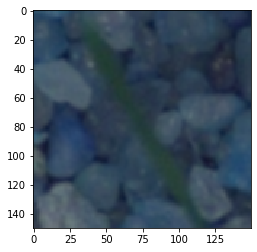

In [17]:
%matplotlib inline

print("Label: {}".format(y[3]))

plt.imshow(X[3]) # Image after a blurring effect
plt.show()

In [119]:
X_train.head(2)

2710    [[[0.23529411764705882, 0.26862745098039215, 0...
1188    [[[0.23921568627450981, 0.27058823529411763, 0...
Name: img_data, dtype: object

In [120]:
train_seedling_df.loc[0, 'seedling_category']

'Black-grass'

## 3.2 Reshape data into shapes compatible with Keras models for 150x150 image sizes

In [18]:
# Reshape training data set to be compatible with Keras models
X_train = np.array([x for x in X_train.ravel()])
X_train.shape

# Reshape test data set to be compatible with Keras models
X_test = np.array([x for x in X_test.ravel()])
X_test.shape

X_validation = np.array([x for x in X_validation.ravel()])
X_validation.shape

(713, 150, 150, 3)

## 3.3 Create images of small 100x100 sizes for comparison

### 3.3.1 Small image with sizes 100x100

In [91]:
small_X_test.head(3)

3817    [[[0.18823529411764706, 0.2549019607843137, 0....
1075    [[[0.11372549019607843, 0.19607843137254902, 0...
296     [[[0.32941176470588235, 0.3254901960784314, 0....
Name: img_data, dtype: object

In [37]:
small_image_df = image_data_df_backup.copy(deep=True)
small_image_df['img_data'] = small_image_df['img_data'].map(lambda image : cv2.resize(image, (100, 100))) 

X = small_image_df['img_data']/255
y = small_image_df['category_name']

#X = np.array(X.values).reshape(X.shape[0], 196, 196, 3)
small_X_train, small_X_test, small_y_train, small_y_test = train_test_split(X, y, test_size=0.3, random_state=42)

number_classes = ""
if type(number_classes) is not int:
    number_classes = len(number_classes)

# Convert string-based labels to numerical labels
small_y_test = small_y_test.astype('category').map(lambda x: label_dict[x])

# Convert numerical labels to multi class labels
small_y_test = tensorflow.keras.utils.to_categorical(small_y_test, (number_classes))

small_X_test = np.array([x for x in small_X_test.ravel()])
small_X_test = small_X_test.astype('float32')
small_X_test.shape

(1425, 100, 100, 3)

## 3.3 Cleanse target dataset for images with 150x150 size

In [19]:
# Generate categorical dictionary for label
label_dict = {}
for i, category in enumerate(category_names):
    label_dict[category] = i
    
print(label_dict)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


Convert labels from digits to one hot vectors

In [20]:
number_classes = ""
if type(number_classes) is not int:
    number_classes = len(number_classes)

# Convert string-based labels to numerical labels
y_test = y_test.astype('category').map(lambda x: label_dict[x])
y_train = y_train.astype('category').map(lambda x: label_dict[x])
y_validation = y_validation.astype('category').map(lambda x: label_dict[x])

# Convert numerical labels to multi class labels
y_train = tensorflow.keras.utils.to_categorical(y_train, (number_classes))
y_test = tensorflow.keras.utils.to_categorical(y_test, (number_classes))
y_validation = tensorflow.keras.utils.to_categorical(y_validation, (number_classes))

In [21]:
# Print the label for y_train[0]
y_train[0] # Show multi class labels

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
# Print the shape for y_train[0]
X_train[0].shape

(150, 150, 3)

# 4.0 CNN Training

## 4.1 Convolutional Neural Network
Define the convolutional network with input shape (150, 150, 3)

In [27]:
# Load a pre-trained model that has been trained a few hours ago
model = tensorflow.keras.models.load_model('pre-trained_size_150x150.h5')

In [71]:
len(category_names)

12

In [26]:
# Create a CNN model
#model = None
#if model is None:
model = Sequential()

# Add a 3x3 filter
model.add(
    Conv2D(32, (3, 3), # Filter size 3x3
           padding='same',
           input_shape=X_train[0].shape
           )
    )

# Add a 3x3 filter and a pooling
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(
    Conv2D(64, (3, 3), padding='same')
    )

# Add a 3x3 filter and a pooling
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten the output of the previous pooling function for final prediction outputs
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(category_names)))
model.add(Activation('softmax'))

In [28]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

In [29]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
    )

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
activation_18 (Activation)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_19 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 74, 74, 64)       

In [31]:
X_train = X_train.astype('float32') # Conversion to float type from integer type.
X_test = X_test.astype('float32')
X_validation = X_validation.astype('float32')
#X_train_np = tensorflow.keras.utils.to_categorical(X_train_np, 12)

# Verify the sape of various features
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(3325, 150, 150, 3)
(712, 150, 150, 3)
(713, 150, 150, 3)


## 4.2 Build a model

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

# Save best weights achieved for future training
model_checkpoint =  ModelCheckpoint(
    'cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1
    )

In [33]:
# Verify that the shape for training and validation data for CNN model is correct
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((3325, 150, 150, 3), (3325, 12), (713, 150, 150, 3), (713, 12))

Train on 3325 samples, validate on 712 samples
Epoch 1/3
3200/3325 [===========================>..] - ETA: 11s - loss: 1.0908 - accuracy: 0.6150
Epoch 00001: val_loss did not improve from 1.05150
3325/3325 [==============================] - 336s 101ms/sample - loss: 1.0866 - accuracy: 0.6168 - val_loss: 1.1354 - val_accuracy: 0.6194
Epoch 2/3
3200/3325 [===========================>..] - ETA: 10s - loss: 1.0189 - accuracy: 0.6344
Epoch 00002: val_loss did not improve from 1.05150
3325/3325 [==============================] - 302s 91ms/sample - loss: 1.0183 - accuracy: 0.6346 - val_loss: 1.1642 - val_accuracy: 0.6264
Epoch 3/3
3200/3325 [===========================>..] - ETA: 10s - loss: 1.0180 - accuracy: 0.6369
Epoch 00003: val_loss did not improve from 1.05150
3325/3325 [==============================] - 301s 90ms/sample - loss: 1.0176 - accuracy: 0.6382 - val_loss: 1.1036 - val_accuracy: 0.6348


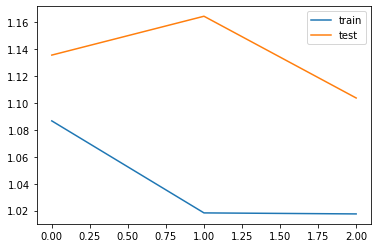

In [51]:
# Set the batch size, number of epochs.
batch_size = 200
num_classes = 10
epochs = 3

# The CNN model is trained over a few days, and saved as a h5 file whenever we stopped the CNN model training process
# The pre-trained model is reloaded for further training
model = tensorflow.keras.models.load_model('pre-trained_size_150x150.h5')

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        X_test, 
        y_test
        ),
    shuffle=True,
    verbose=1,
    callbacks=[
               early_stopping,
               model_checkpoint
               ]
    )

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

The train and validation accuracy have diverged so we should stop the model training to reduce overfitting.

## 4.3 Save or retrain 100x100 images
Trained CNN network models for 100x100 image sizes are stored in h5 files that can be retrieved for retraining or prediction.


In [81]:
# Save the model for future training
model.save('pre-trained_size_100x100.h5') 

In [84]:
# Load a model that has been trained and stored as a h5 file
model = tensorflow.keras.models.load_model('pre-trained_100x100.h5')

## 4.4 Save or retrain 150x150 images
Trained CNN network models for 150x150 image sizes are stored in h5 files that can be retrieved for retraining or prediction.

In [ ]:
# Save the model for future training
model.save('pre-trained_size_150x150.h5') 

In [ ]:
# Load a model that has been trained and stored as a h5 file
model = tf.keras.models.load_model('pre-trained_size_150x150.h5')

# 5.0 Fit and evaluate model and print confusion matrix. (10 Marks)

## We found that image sizes 100x100 have the best prediction accucacy for test data, after trying to use two image sizes, namely 100x100 and 150x150 to train some CNN models. Consequently, we use CNN model that is trained with image sizes 100x100 without Gaussian Blurring for evaluation

## 5.1 Evaluate the accuracy of the test model trained using image sizes 100x100

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# Load a CNN model from a h5 file with a model trained in previous steps using image sizes 100x100
new_model = tensorflow.keras.models.load_model('pre-trained_100x100.h5')

# Score trained model.
scores = new_model.evaluate(small_X_test, small_y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.8599260802018015
Test accuracy: 0.7361404


The prediction accuracy for test dataset is 0.73 in this case, which is reasonable for large data set.

## 5.2 Fit the trained model to the test dataset with small image size 100x100

In [39]:
# Flatten the multi class target dataset into an array
y_pred = new_model.predict(small_X_test)
y_pred_array = [np.array((np.argmax(data)).flatten()) for data in y_pred]
y_pred_array = [data.astype(int) for data in y_pred_array]

# Flatten the multi class target dataset into an array
y_test_array = [np.array((np.argmax(data)).flatten()) for data in small_y_test]
y_test_array = [data.astype(int) for data in y_test_array]

In [40]:
cm = confusion_matrix(y_test_array, y_pred_array)
print(cm)

[[ 24   0   1   0   4   2  52   1   0   0   0   3]
 [  0  96   3   0   0   3   0   1   4   4   5   4]
 [  0   1  63   1   3   5   2   1   8   1   1   0]
 [  0   0   0 178   0   2   0   4   0   5   3   1]
 [  4   0   2   0  22  14  21   0   1   0   0   1]
 [  2   0   2   6   1 108   9   1   3   2   8   1]
 [  9   0   0   0   3   8 172   0   1   0   2   3]
 [  0   1   0  10   0   3   1  49   0   1   1   4]
 [  1   3   2   8   0   6   4   1 101   2   0   8]
 [  0   0   0   7   0   3   0   3  11  32   1   1]
 [  0   2   1   1   0   1   1   4   0   3 137   1]
 [  2   3   0   4   5  19   0   4   4   0  10  67]]


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


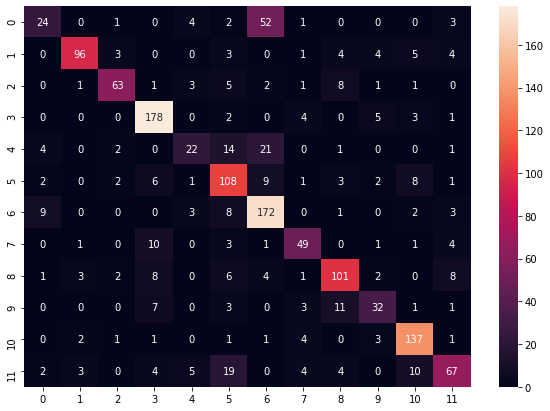

In [46]:
import seaborn as sns
data_range = [data for data in range(12)]
print(data_range)

df_cm = pd.DataFrame(cm, index = [i for i in data_range],
                     columns = [i for i in data_range])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')

The confusion matrix shows that the trained CNN can predict most types of glass accurately except black glass, common wheat, and sugar beet. Further work needed to compare images for black glass that are wrongly classified as loose silky bent.

# 6.0 Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]. (5 Marks)

## 6.1 Prediction for x_test vs y predicted for image sizes 100x100

In [47]:
Great a list of dictionary dataset to link index numbers to seedling names.
label_dict = {}
for i, category in enumerate(category_names):
    label_dict[i] = category
    
print(label_dict)

{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


--------------------
The actual result for Charlock, which is test[2]
Actual test data = Charlock, and predicted test data = Charlock


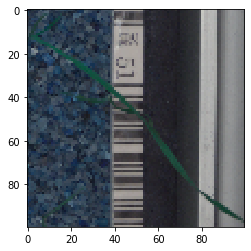

--------------------
The actual result for Fat Hen, which is test[3]
Actual test data = Fat Hen, and predicted test data = Fat Hen


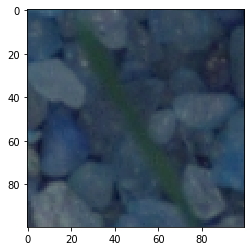

--------------------
The actual result for Maize, which is test[33]
Actual test data = Maize, and predicted test data = Maize


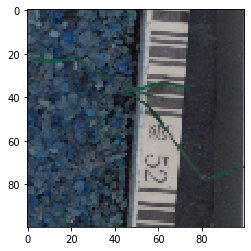

--------------------
The actual result for Cleavers, which is test[36]
Actual test data = Cleavers, and predicted test data = Cleavers


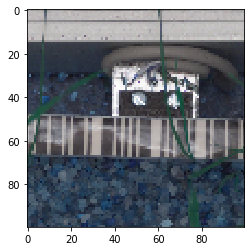

--------------------
The actual result for Fat Hen, which is test[59]
Actual test data = Fat Hen, and predicted test data = Fat Hen


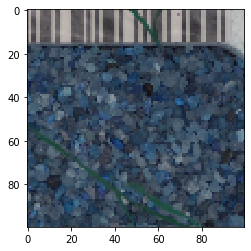

In [48]:
# Look for test data in the following indexes
for index in [2,3,33,36,59]:
    y_test_actual = y_test_array[index]
    y_test_prediction = y_pred_array[index]
    print("--------------------")
    print(f"The actual result for {label_dict[y_test_actual[0]]}, which is test[{index}]")
    print(f"Actual test data = {label_dict[y_test_actual[0]]}, and predicted test data = {label_dict[y_test_prediction[0]]}")
    plt.imshow(X[index]) # Show the image
    plt.show()